<a href="https://colab.research.google.com/github/bheath015/Protein-Atlas-Image-Classification/blob/brian/CIS519Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57da6000 @  0x7f1a03ba92a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
############################################################
# Imports
############################################################
# Include your imports here, if any are used.

!pip install cnn_finetune
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from google.colab import drive
from cnn_finetune import make_model

    100% |████████████████████████████████| 61kB 3.7MB/s 
  Running setup.py bdist_wheel for cnn-finetune ... - \ done
  Stored in directory: /root/.cache/pip/wheels/5b/cf/68/e5add4bdc799cc61ea287974d0ac275dc2275fe9934463fdab
  Running setup.py bdist_wheel for pretrainedmodels ... - \ done
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Running setup.py bdist_wheel for munch ... - done
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built cnn-finetune pretrainedmodels munch


In [0]:

#This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

#This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
def extract_data(x_data_filepath, y_data_filepath):
    X = np.load(x_data_filepath)
    y = np.load(y_data_filepath)
    return X, y

In [0]:
############################################################
# Extracting and loading data
############################################################
class Dataset(Dataset):
    """CIFAR-10 image dataset."""
    def __init__(self, X, y, transformations=None, normalize=True):
        self.len = len(X) 
        
        # normalize the images
        if normalize:
            for j in range(X.shape[0]):
                X[j,:,:,:] = normalize_image(X[j,:,:,:])
            
        if torch.cuda.is_available():
          self.x_data = torch.from_numpy(X).float().cuda()
          self.y_data = torch.from_numpy(y).long().cuda()
        else:
          self.x_data = torch.from_numpy(X).float()
          self.y_data = torch.from_numpy(y).long()
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [0]:
############################################################
# Convolutional Neural Network
############################################################
class ConvolutionalNN(nn.Module):
    """ 
        (1) Use self.conv1 as the variable name for your first convolutional layer
        (2) Use self.pool as the variable name for your pooling layer
        (3) User self.conv2 as the variable name for your second convolutional layer
        (4) Use self.fc1 as the variable name for your first fully connected layer
        (5) Use self.fc2 as the variable name for your second fully connected layer
        (6) Use self.fc3 as the variable name for your third fully connected layer
    """
    def __init__(self):
        
        super(ConvolutionalNN, self).__init__()
        
        # Conv2D: (input channels, output channels, filter size, stride, padding)
        self.conv1 = nn.Conv2d(3, 7, 3, 1, 0) 
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(7, 16, 3, 1, 0) 

        self.fc1 = nn.Linear(16*13*13, 130) 
        self.fc2 = nn.Linear(130, 72) 
        self.fc3 = nn.Linear(72, 10) 
        
    def forward(self, x):
        
        # tensor size (x, y, z, z) <- x: batch size, y: number of channels, z: dimension of each channel
        
        # out = (64, 7, 30, 30) <- 32x32 input with 3x3 filter: 30x30 output (32-(3-1)=30)  
        out = F.relu(self.conv1(x))
        
        # out = (64, 7, 15, 15) <- 30x30 input with 2x2 filter: 15x15 output (30/2=15)
        out = self.pool(out)
        
        # out = (64, 16, 13, 13) <- 13x13 input with 3x3 filter: 13x13 output (15-(3-1)=13)  
        out = F.relu(self.conv2(out))

        # 3 fully connected layers (16x13x13 -> 130 -> 72 -> 10)
        out = out.view(out.size(0), -1) # flatten each example: out = (64, ") <- batch_size x (16x13x13)
        out = F.sigmoid(self.fc1(out))
        out = F.sigmoid(self.fc2(out)) 
        out = F.sigmoid(self.fc3(out))
        
        return out
    
    """ 
        Please do not change the functions below. 
        They will be used to test the correctness of your implementation 
    """
    def get_conv1_params(self):
        return self.conv1.__repr__()
    
    def get_pool_params(self):
        return self.pool.__repr__()

    def get_conv2_params(self):
        return self.conv2.__repr__()
    
    def get_fc1_params(self):
        return self.fc1.__repr__()
    
    def get_fc2_params(self):
        return self.fc2.__repr__()
    
    def get_fc3_params(self):
        return self.fc3.__repr__()

In [0]:
def AdvancedCNN(model,num_classes=27,input_size=(512,512)):
    CNN_model = make_model(model, num_classes=num_classes, pretrained=True, input_size=input_size)
    
    return CNN_model
    

In [0]:

############################################################
# Run Experiment
############################################################
def run_experiment(neural_network, train_loader, test_loader, loss_function, optimizer):
    """
    Runs experiment on the model neural network given a train and test data loader, loss function and optimizer.

    Args:
        neural_network (NN model that extends torch.nn.Module): For example, it should take an instance of either
                                                                FeedForwardNN or ConvolutionalNN,
        train_loader (DataLoader),
        test_loader (DataLoader),
        loss_function (torch.nn.CrossEntropyLoss),
        optimizer (optim.SGD)
    Returns:
        tuple: First position, testing accuracy.
               Second position, training accuracy.
               Third position, training loss.

               For example, if you find that
                            testing accuracy = 0.76,
                            training accuracy = 0.24
                            training loss = 0.56

               This function should return (0.76, 0.24, 0.56)
    """
    if torch.cuda.is_available():
       neural_network.cuda()
    
    max_epochs = 100
    train_loss = np.zeros((max_epochs))
    train_accuracy = np.zeros((max_epochs))
    test_accuracy = np.zeros((max_epochs))
    
    # optimize weights
    for epoch in range(max_epochs):
    
        print('Training neural network...')
        for i, data in enumerate(train_loader, 0):            
            train_batch_NN(data, neural_network, loss_function, optimizer) # train on batch

        print('Calculating Statistics over Epochs:')
        # get training loss and accuracy for this epoch  
        train_loss[epoch], train_accuracy[epoch] = get_train_statistics(train_loader, neural_network, loss_function)
        test_accuracy[epoch] = get_test_statistics(test_loader, neural_network)
        print("epoch:", epoch, "loss:", train_loss[epoch], "train accuracy:", train_accuracy[epoch], "test accuracy:", 
              test_accuracy[epoch])
        
    return (train_loss, train_accuracy, test_accuracy)

In [0]:
def normalize_image(image):
    """
    Normalizes the RGB pixel values of an image.

    Args:
        image (3D NumPy array): For example, it should take in a single 3x32x32 image from the CIFAR-10 dataset
    Returns:
        tuple: The normalized image
    """
    mean = np.mean(image, axis=(1,2))
    std = np.std(image, axis=(1,2))
    normalized_image = ((image[0,:,:] - mean[0]) / std[0], 
                        (image[1,:,:] - mean[1]) / std[1], 
                        (image[2,:,:] - mean[2]) / std[2])
    return np.stack(normalized_image, axis=0)

In [0]:
# REQUIRED METHOD - Function to train a single batch in the NN (used in run_experiment())

def train_batch_NN(data, neural_network, loss_function, optimizer):

    # Get inputs and labels from data loader 
    inputs, labels = data

    #print(inputs.size())
    inputs, labels = Variable(inputs), Variable(labels)

    if torch.cuda.is_available():
      inputs.cuda()
      labels.cuda()


    # Feed the input data into the network 
    y_pred = neural_network(inputs)


    # Calculate the loss using predicted labels and ground truth labels
    optimizer.zero_grad()

    loss = loss_function(y_pred, labels)


    # backpropogates to compute gradient
    loss.backward()

    # updates the weghts
    optimizer.step()

In [0]:
# REQUIRED METHOD - Function to get loss and accuracy across all training examples in the NN (used in run_experiment())

def get_train_statistics(train_loader, neural_network, loss_function):
    
    correct = 0
    sum_loss = 0
    
    for i, data in enumerate(train_loader, 0):

        for i, data in enumerate(train_loader, 0):
          
            # Get inputs and labels from data loader 
            inputs, labels = data
            
            inputs, labels = Variable(inputs), Variable(labels)
            
            if torch.cuda.is_available():
              inputs.cuda()
              labels.cuda()
            
        
            # Feed the input data into the network 
            y_pred = neural_network(inputs)
            
            # Calculate the loss using predicted labels and ground truth labels
            loss = loss_function(y_pred, labels)

            
            # convert predicted labels into numpy
            nploss= loss.cpu().data.numpy()
            sum_loss = sum_loss + nploss
            
            
            y_pred_np = y_pred.cpu().data.numpy()
            label_np = labels.cpu().data.numpy().reshape(len(labels),1)
            
              
            pred_np = np.argmax(y_pred_np, axis=1)
            
            for j in range(y_pred_np.shape[0]):
                if pred_np[j] == label_np[j]:
                    correct += 1
    
    # calculate the accuracy across batches
    train_accuracy = float(correct)/float(len(train_loader.dataset))
    
    return sum_loss, train_accuracy

In [0]:
# REQUIRED METHOD - Function to accuracy across all test examples in the NN (used in run_experiment())

def get_test_statistics(test_loader, neural_network):
    
    correct_test = 0
    
    for i, data in enumerate(test_loader, 0):

            # Get inputs and labels from data loader 
            inputs, labels = data

            #print(inputs.size())
            inputs, labels = Variable(inputs), Variable(labels)
            
            if torch.cuda.is_available():
              inputs.cuda()
              labels.cuda()


            # Feed the input data into the network 
            y_pred_test = neural_network(inputs)


            # convert predicted laels into numpy
            y_pred_np_test = y_pred_test.cpu().data.numpy()
            label_np_test = labels.cpu().data.numpy().reshape(len(labels),1)
           
          
            # calculate the training accuracy of the current model
            pred_np_test = np.argmax(y_pred_np_test, axis=1)


            for j in range(y_pred_np_test.shape[0]):
                if pred_np_test[j] == label_np_test[j]:
                    correct_test += 1
    
    # calculate the accuracy across batches
    test_accuracy = float(total_correct) / float(len(test_loader.dataset))
    
    return test_accuracy

In [0]:
# Function to plot the loss and training accuracy over epochs

def plot_epoch_stats(loss, train_accuracy, test_accuracy):
    
    max_epochs = 100
    print("final training accuracy: ", train_accuracy[max_epochs-1])
    print("final test accuracy: ", test_accuracy[max_epochs-1])
    epoch_number = np.arange(0,max_epochs,1)

    # Plot the loss over epoch
    plt.figure()
    plt.plot(epoch_number, loss)
    plt.title('Total Loss over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    # Plot the training accuracy over epoch
    plt.figure()
    plt.plot(epoch_number, train_accuracy)
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('accuracy')
    
    # Plot the testing accuracy over epoch
    plt.figure()
    plt.plot(epoch_number, test_accuracy)
    plt.title('Testing Accuracy over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('accuracy')

In [0]:
# RUN CODE BELOW HERE

In [0]:
!pip install kaggle
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

In [0]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
!kaggle competitions list
!kaggle competitions download  -c human-protein-atlas-image-classification -p /content/kaggle

In [0]:
!unzip -q /content/kaggle/test.zip

In [0]:
test_files = os.listdir('/content/')
import 
# for i in range(len())

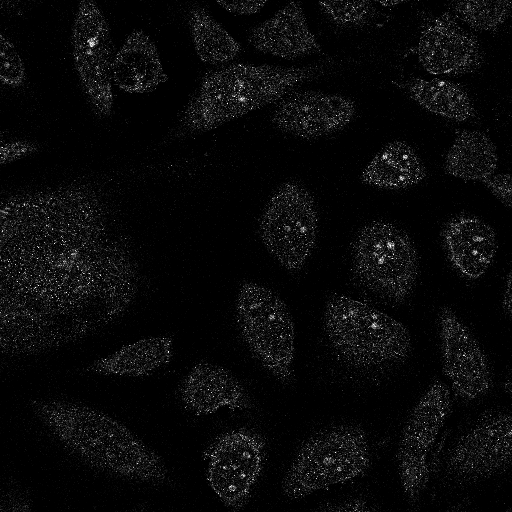

In [16]:
from IPython.display import Image
Image(filename='/content/a142c680-bacb-11e8-b2b8-ac1f6b6435d0_green.png') 

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

mlb = MultiLabelBinarizer()

train_labels_file_path = '/content/kaggle/train.csv'

X_train = []
y_train = []

with open(train_labels_file_path) as train_labels_file:
    labels_df = pd.read_csv(train_labels_file)

rows = labels_df.shape[0]
for i in range(rows):
    labels_df['Target'][i] = labels_df['Target'][i].split(' ')

out = pd.DataFrame(mlb.fit_transform(labels_df['Target']), columns=mlb.classes_, index=labels_df.index)
print(out)


       0  1  10  11  12  13  14  15  16  17 ...  25  26  27  3  4  5  6  7  8  \
0      1  0   0   0   0   0   0   0   1   0 ...   0   0   0  0  0  0  0  0  0   
1      1  1   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  0  0  1  0   
2      0  0   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  1  0  0  0   
3      0  1   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  0  0  0  0   
4      0  0   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  0  0  0  0   
5      1  0   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  0  0  0  0   
6      0  0   0   0   0   0   0   0   0   0 ...   1   0   0  0  0  0  0  0  0   
7      1  0   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  0  0  0  0   
8      1  0   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  0  0  0  0   
9      0  0   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  0  0  1  0   
10     0  0   0   0   0   0   0   0   0   0 ...   0   0   0  0  0  0  0  0  0   
11     0  0   0   0   0   0 

In [0]:
# Initialize constants
'''
train_images_file_path = '/content/gdrive/My Drive/Colab Notebooks/train'
test_images_file_path = '/content/gdrive/My Drive/Colab Notebooks/test'
test_labels_file_path = '/content/gdrive/My Drive/Colab Notebooks/cifar10-data/test_labels.npy'

# create train and test data loaders
X_train, y_train = extract_data('gdrive/My Drive/?.npy', 'gdrive/My Drive/?.npy') # ? examples ################################ GPU
X_test, y_test = extract_data('gdrive/My Drive/?.npy', 'gdrive/My Drive/?.npy') # ? examples ################################ GPU
'''
# specify the loss function
loss_function = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
   loss_function.cuda()

In [0]:
#test
x_train = 'drive/My Drive/COLAB/CIS 519/HW3/cifar10-data/train_images.npy'
y_train = 'drive/My Drive/COLAB/CIS 519/HW3/cifar10-data/train_labels.npy'
X_train,y_train = extract_data(x_train,y_train)


  
x_test = 'drive/My Drive/COLAB/CIS 519/HW3/cifar10-data/test_images.npy'
y_test= 'drive/My Drive/COLAB/CIS 519/HW3/cifar10-data/test_labels.npy'
X_test, y_test = extract_data(x_test,y_test)

train_dataset = Dataset(X_train, y_train, normalize=False)
test_dataset = Dataset(X_test, y_test, normalize=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

In [0]:
# Run Experiment and save results

train_dataset = Dataset(X_train, y_train, normalize=False)
test_dataset = Dataset(X_test, y_test, normalize=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

conv_raw_net = ConvolutionalNN() # create the NN
optimizer = optim.SGD(conv_raw_net.parameters(), lr=0.001, momentum=0.9) # specify the optimizer
(loss, train_accuracy, test_accuracy) = run_experiment(conv_raw_net, train_loader, test_loader, loss_function, optimizer)

# np.save("gdrive/My Drive/statistics/conv_loss.npy", loss)
# np.save("gdrive/My Drive/statistics/conv_train_accuracy.npy", train_accuracy)
# np.save("gdrive/My Drive/statistics/conv_test_accuracy.npy", test_accuracy)

In [0]:
# Run Experiment on Advanced CNN:

# get the name of model here https://pypi.org/project/cnn-finetune/

name = 'resnet18'
CNN_Model = AdvancedCNN(name)
optimizer = optim.SGD(CNN_Model.parameters(), lr=0.001, momentum=0.9)

(loss, train_accuracy, test_accuracy) = run_experiment(CNN_Model, train_loader, test_loader, loss_function, optimizer)
plot_epoch_stats(loss, train_accuracy, test_accuracy)

Training neural network...
Calculating Statistics over Epochs:


KeyboardInterrupt: ignored